# Heat Capacity for $\rm{Yb_2Ti_2O_7}$

This notebook computes the heat capacity of $\rm{Yb_2Ti_2O_7}$ from long-pulse data and applies a demagnetization correction based on base temperature magnetization data

## Theory

Most of the data for this experiment was collected with the long-pulse method. In this method, one applies a long heat pulse to the sample, and then records the temperature as the sample cools back to the cryostat temperature. One can compute heat capacity with the following equations:

$Q = C \frac{dT_s}{dt} + P(t)$, and  $\frac{dQ}{dx} =\kappa \frac{dT}{dx}$

Now in our setup (Quantum Design PPMS dilution refrigerator puck), we know the thermal conductivity of the wire connecting the sample to the puck. Thus, we can integrate over $dx$:

$\int \frac{dQ}{dx} dx = \int \kappa \frac{dT}{dx}dx $

$Q = \int_{T_b}^{T_s} \kappa ~dT $, 

where $T_s$ is the sample temperature and $T_b$ is the base temperature (temperature of the heat capacity puck). Now, we can combine the two equations above by setting $Q=Q$:
$$C \frac{dT}{dt} + P(t) = \int_{T_b}^{T_s} \kappa ~dT$$

Now if $\kappa$ were a constant, we could just pull it out of the integral and the equation would be $C \frac{dT}{dt} + P(t) = \kappa  (T_b-T_s)$. But $\kappa$ varies with temperature in a nonlinear way, so we have to keep the integral in the equation. Solving for $C$, we get our final equation:

\begin{equation}
C = \frac{ \int_{T_b}^{T_s} \kappa ~dT - P(t) } {\frac{dT_s}{dt}}
\end{equation}


## Additional Data Processing Steps

The above equation gives the theory behind how heat capacity is computed, and it is not so complicated. However, we found that the raw PPMS data needed to be processed a bit before we could accurately apply the heat capacity eqation. There are three additional steps taken before heat capacity could be computed:

First, we found that temperature needed to be re-computed from thermometer resistance. When $(T_b-T_s)$ becomes significant, we found that that different heat pulses are inconsistent if we use the $T_s$ recorded in the raw data file. However, when we re-computed the temperature from resistance (using the T vs R curves in the calibration file), the data was self-consistent. We think the PPMS software must make a linear approximation in the T vs. R curve, leading to inaccurate temperatures as $(T_b-T_s)$ becomes large. In any case, all temperature data points needed to be re-computed from thermometer resistance.

Second, we found that the data needed to be smoothed before taking the derivative $\frac{dT_s}{dt}$. A derivative of noisy data is almost unintelligible, so a simple moving average was applied to the data. There is also an option to smooth the data after taking the derivative, but we found it was not usually necessary.

Third, we found that the heating pulses did not yield self-consistent data. When the two previous corrections were applied, the data taken upon the sample cooling were all beautifully self-consistent, but the heating pulses were not. We are not sure why this is, but we suspect that the heater power (like the temperatre) is recorded incorrectly. We have as of yet been unable to resolve this issue, so we ignore the heating pulse data and only use the data upon cooling.

All these steps are programmed into the class 'LongHCPulse', which automatically imports calibration data and computes heat capacity from long pulses. It also recognizes short pulses (with a small temperature rise) and treats them separately. It can also plot heat capacity in various ways, compute entropy, and apply demagnetization correction. 

Now, let's get on to the code itself.

In [1]:
# Code to extract heat capacity from a long pulse in PPMS measurement
# Allen Scheie
# Begun August, 2016

# import libraries
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter
import sys
from LongHCPulse import LongHCPulse # class to compute heat capacity

In [2]:

# Find Yb2Ti2O7 molar mass
mmYb = 173.201 	# g/mol   (from WolframAlpha.com)
mmTi = 47.867	# g/mol
mmO = 15.9994	# g/mol
MMYbTiO = (2*mmYb + 2*mmTi + 7*mmO)

# Import data and compute heat capacity (this can take a minute or two)
datafile = 'Yb2Ti2O7_longpulse.raw'
DRcalfile = 'DRPuck27.cal'
YbTiO = LongHCPulse(datafile=datafile,calfile=DRcalfile,
	sampmass=1.04,molarmass=MMYbTiO, scaleshortpulse=1e-6/1.04e-3*MMYbTiO)   # sample mass is in mg

# Re-scale wire thermal conductivity (see Appendix A)
YbTiO.Kw[1] = YbTiO.Kw[1]*0.65 + 2.5e6*YbTiO.Kw[1]**2

# Compute Heat Capacity
YbTiO.heatcapacity(smoothlevel=0)
# Scale data to per Yb ion instead of per F.U.:
YbTiO.scale(2)

**************** LongHCPulse v 1.2 ******************
 please cite   https://arxiv.org/pdf/1705.07129.pdf
******************************************************
 - Importing data...
 100%
 - Computing Heat Capacity...
 100%


## Demagnetization Correction

The data that we took was on a small (approximately) rectangular puck of dimensions 0.2mm x 0.94mm x 0.92mm, yielding a demagnetization factor of roughly 0.6. (Computed with http://www.magpar.net/static/magpar/doc/html/demagcalc.html .) We are interested in plotting the data against $H_{int}$ instead of $H_{ext}$, so we need to correct for the internal demagnetizing field.

The demagnetization factor is computed as follows:
$H_{int} = H_0 - D M$ where $H_0$ is the applied external field, $D$ is demagnetization factor, and $M$ is the magnetization of the material.
Thus, if we want $H_{demag}$, we simply subtract the magnetization.

### Units

As usual, we have to pay very close attention to units. The magnetization data we have is measured in units of Bohr magnetons per formula unit, which are units of J/T. To convert magnetization to magnetic field, we need to multiply by $\mu_0 \mu_B$ to get units of $ \mu_0 M = \big(\rm{\frac{T m}{A}} \big)   \big(\rm{\frac{J}{T}} \big) = \rm{\frac{J m}{T}} = \rm{\frac{J}{m^2T}m^3} = \rm{Tm^3}$. 
To turn magnetization into magnetic field (units of Tesla), we need to then divide the magnetization by the volume of the unit cell. Therefore, to convert magnetization to field, we need to multiply by $\mu_0 \mu_B /v$ where $v$ is the volume per magnetic ion:
$$H_{int} = H_0 - \frac{\mu_0 \mu_B}{v} D M$$


### Finding $H_{int}$

We begin by importing $\rm{Yb_2Ti_2O_7}$ magnetization data taken at 50mK. This data was taken on a near-perfect sphere of Yb2Ti2O7 (radius 4.7 mm), which means that the demagnetization factor should be $1/3$. Thus, we apply the correction $H_{int} = H_0 - \frac{\mu_0 \mu_B}{v} 1/3 M$ to get $M(H_{int})$ instead of $M(H_0)$.

Once we have $M(H_{int})$, we can solve for $H_{int}$ given $H_0$ and our puck's demagnetization factor $D$. However, we cannot directly solve for $H_{int}$, because it appears twice in the new equation: $H_{int} = H_0 - \mu_0 D M(H_{int})$. We need a numerical solution. In this case, I use the bisection method just because it's guaranteed to converge. (See function 'scaleDemagFactor' in the 'LongHCPulse' class.)

In [3]:
#****************************************************
####Scale magnetic fields by demagnetization factor:
#****************************************************

#Formula unit volume   (unit cell volume divided by 8, becuase there are 16 Yb ions per unit cell)
FUvol =  10.01247e-10 **3 / 8 #(m^3)
mu_B = 9.27401e-24
mu0 = 4*np.pi*1e-7

magvsfield = 'YbTiO_MvsB_100mK.txt'
MvsB = np.genfromtxt(magvsfield, skip_header=1, unpack=True)
MvsB[1] = MvsB[1]*mu_B/FUvol  #convert to A/m from mu_B/F.U.
MvsB[0] = MvsB[0] - mu0*1/3*MvsB[1]   # Correct for sphere demagnetization (!)
MvsB[0] = MvsB[0]*10000  #convert to Oe from T

#plt.figure()
#plt.plot(MvsB[0],MvsB[1])
DemagFactor = 0.68

YbTiO.scaleDemagFactor(demagFac = DemagFactor, magvsfield = MvsB)

Scaling demagnetization...


In [4]:
# Sandbox for plotting B_int vs. B_ext

# plt.figure(figsize=(4,4))
# plt.plot(YbTiO.CombB/10000, YbTiO.ScaledCombB/10000)
# plt.ylim(-0.01,0.9)
# plt.xlabel("$B_{ext}$")
# plt.ylabel("$B_{int}$")
# plt.tight_layout()

In [5]:
## Some clean-up of heat capacity data:

# Delete values which contributed to heating over peak (because there's hysteresis on heating vs. cooling)
for i in range(3,10):
	YbTiO.HC[i] *= np.nan

for i in range(len(YbTiO.smoothedData)):
    maxT = YbTiO.rawdata[i,1,-1,0]  #maximum temperature reached in heating pulse
    for k in range(2):
        for j in range(1,len(YbTiO.smoothedData[i,0,:,0])-2):
            Ts = YbTiO.smoothedData[i,1,j,k]
            if ((Ts > 0.3) and ((maxT  - Ts)/(maxT-YbTiO.Tb[i]) < 0.31)): 
                YbTiO.HC[i,j,k] = np.nan
    
#Get rid of points at end of cooling pulses with poor overlap. These points are unreliable as they are 
# getting near to equilibrium, and the temperature gradient accuracy is lower.
for i in range(len(YbTiO.Bfield)):
    if (YbTiO.T[i,0,0] > 0.42) and (YbTiO.Bfield[i] > 5000):
        YbTiO.HC[i, YbTiO.T[i,:,1]<0.49,1] *= np.nan



# Plot Data

<IPython.core.display.Javascript object>


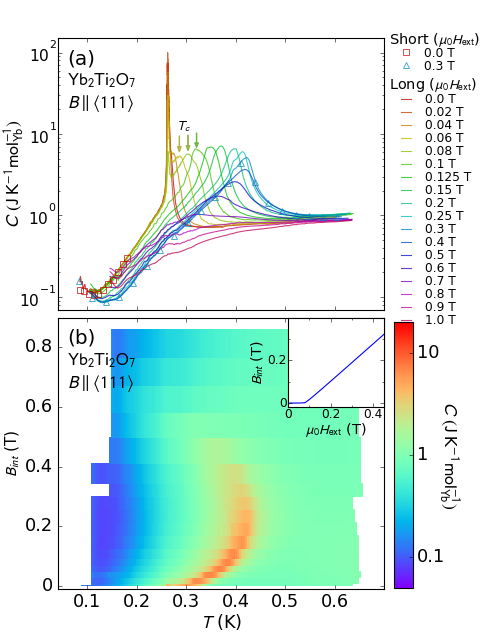

/home/allen/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:812: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/allen/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
LongHCPulse.py:935: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Barray in ['All', 'all']:


 combining traces...


/home/allen/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1121: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markeredgecolor != ec:


In [6]:
# Clear labels
YbTiO.labels = []
YbTiO.shortpulselabels = []



#Formatting stuff
#########################################################################
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans', 'font.size': 16}
plt.rcParams.update(params)

def my_formatter(x, pos):
    """Format 0.0 as 0"""
    if x == 0: return '{:g}'.format(x)
    else: return x
    
def myLogFormat(y,pos):
    # Find the number of decimal places required
    decimalplaces = int(np.maximum(-np.log10(y),1))     # =0 for numbers >=1
    # Insert that number into a format string
    formatstring = '{{:.{:1d}f}}'.format(decimalplaces)
    # Return the formatted tick label
    return formatstring.format(y)
############################################################################

#***************
# Plot the HC data in mesh grid form
#***************

f, ax = plt.subplots(2,1,sharex=True,figsize=(6,8))

xarray = np.arange(0.0,0.9,0.004)
intens, Bedg = YbTiO.meshgrid(Tarray =xarray,Barray='All')

meshdata = ax[1].pcolormesh(xarray,Bedg/10000,intens,rasterized = True, 
	cmap = 'rainbow', norm=LogNorm(vmin=0.05, vmax=20))

#meshdata = ax[0].pcolormesh(xarray,Bedg/10000,intens,rasterized = True, cmap = 'rainbow', vmin=0, vmax=5)


#ax[0].set_xlabel("Temperature (K)", fontsize=14)
ax[1].set_ylabel('$B_{int}$ (T)',fontsize=14,labelpad = 4)
ax[1].set_ylim(-100./10000,9000/10000.)
ax[1].yaxis.set_major_formatter(FuncFormatter(my_formatter))
ax[1].set_xlabel("$T$ (K)", labelpad = 1) 

##### Colorscale bar
cax = f.add_axes([0.82,0.082,0.04,0.415])
f.subplots_adjust(left = 0.12,right = 0.80, bottom = 0.08, top = 0.94,wspace =0.02,hspace = 0.03)
cb=plt.colorbar(meshdata,cax=cax)
#cb=plt.colorbar(meshdata,ax=ax[0])
cb.set_label('$C$ $(\\rm{J\> K^{-1} mol^{-1}_{Yb}})$', rotation = -90, labelpad = 14)
cb.ax.set_yticklabels(['{:.1f}'.format(0.1), '{:.0f}'.format(1.0), '{:.0f}'.format(10)])



#********************************************
# Plot the HC data in line plots
#***************

BvaluesToPlot = np.array([0,200, 400, 600, 800, 1000, 1250, 1500, 2000, 2500, 3000,
		4000,5000,6000, 7000,8000, 9000, 10000])
#BvaluesToPlot = [0,200, 400, 600, 800, 1000, 1250, 3000,
#		8000, 9000, 10000]

#YbTiO.lineplot(ax[0],BvaluesToPlot)

YbTiO.lineplotCombine(ax[0],BvaluesToPlot,smooth=0, demag=False)
#################YbTiO.lineplotCombine(ax[0],BvaluesToPlot,smooth=0)

ax[0].set_ylabel("$C$ $(\\rm{J\> K^{-1} mol^{-1}_{Yb}})$", labelpad = -6)
ax[0].set_yscale('log')
#ax[0].yaxis.set_major_formatter(FuncFormatter(myLogFormat))
ax[0].tick_params(axis='y', which='major', pad=1, labelsize=14)

# Original
###ax[0].set_ylim(0.04,169)
ax[0].set_ylim(0.07,149)
ax[0].set_xlim(0.04,0.7)

#Add legends
short_legend=ax[0].legend(handles=YbTiO.shortpulselabels,labelspacing = 0,handlelength=1.4,
	fontsize=11,frameon=False, bbox_to_anchor=(1.25, 1.01),numpoints=1)
long_legend=ax[0].legend(handles=YbTiO.labels,labelspacing = 0,handlelength=1.4,fontsize=11,
	frameon=False, bbox_to_anchor=(1.3, 0.84))
ax[0].add_artist(short_legend)
#####ax[0].text(1.015, 0.98, 'Adiabatic',transform=ax[0].transAxes, fontsize=13)
#####ax[0].text(1.015, 0.815, 'Long Pulse',transform=ax[0].transAxes, fontsize=13)
ax[0].text(1.015, 0.98, 'Short ($\\mu_0H_{\\rm ext}$)',transform=ax[0].transAxes, fontsize=13)
ax[0].text(1.015, 0.815, 'Long ($\\mu_0H_{\\rm ext}$)',transform=ax[0].transAxes, fontsize=13)


# And some formatting at the end to clean things up:
subp = ['(a)','(b)']
for i, a in enumerate(ax):
# 	a.text(-0.16,1.02,subp[i],horizontalalignment='left',weight='heavy',
# 		verticalalignment='top',fontsize=18,transform=a.transAxes)
# 	a.text(0.03,0.97,'$\\rm{Yb_2Ti_2O_7}$\n $B \parallel (111)$',horizontalalignment='left',
# 		verticalalignment='top',transform=a.transAxes)
	a.text(0.03,0.96,subp[i],horizontalalignment='left',
		verticalalignment='top',fontsize=18,transform=a.transAxes)
	a.text(0.03,0.87,'$\\rm{Yb_2Ti_2O_7}$\n$B \parallel \\langle 111 \\rangle$',horizontalalignment='left',
		verticalalignment='top',transform=a.transAxes)

arrowhw, arrowhl = 0.008, 1.0
colorscale = 0.8
ax[0].arrow(0.2861, 9.5, 0, -2.5, 
            head_width=arrowhw, head_length=arrowhl, fc=YbTiO.labels[3]._color*colorscale, 
            ec=YbTiO.labels[3]._color*colorscale)

ax[0].arrow(0.303688807267, 9.7, 0, -2.5, 
            head_width=arrowhw, head_length=arrowhl, fc=YbTiO.labels[4]._color*colorscale, 
            ec=YbTiO.labels[4]._color*colorscale)

ax[0].arrow(0.32103206558, 10.3, 0, -2.5, 
            head_width=arrowhw, head_length=arrowhl, fc=YbTiO.labels[5]._color*colorscale, 
            ec=YbTiO.labels[5]._color*colorscale)

ax[0].text(0.28, 11, '$T_c$', fontsize=12)
    


########################################################################
###  Plot B_int vs. B_ext as an inset
########################################################################

left, bottom, width, height = [0.6, 0.3635, 0.2, 0.14]
#left, bottom, width, height = [0.56, 0.39, 0.24, 0.1135]   # Original place, sublpot b
#left, bottom, width, height = [0.56, 0.555, 0.24, 0.10]  #within subplot a
inset2 = f.add_axes([left, bottom, width, height])

inset2.plot(YbTiO.CombB/10000, YbTiO.ScaledCombB/10000)
# inset2.set_ylim(-0.05,0.9)
# inset2.set_xlim(0,0.95)
inset2.set_ylim(-0.02,0.4)
inset2.set_xlim(0,0.45)

# inset2.set_ylim(-0.05,0.9)
#inset2.set_xlim(0.01,0.95)
#inset2.set_xscale('log')
inset2.set_xlabel("$\\mu_0H_{\\rm ext}$ (T)", fontsize = 13, labelpad=0)
inset2.set_ylabel("$B_{int}$ (T)", fontsize = 13, labelpad=1)
inset2.tick_params(axis='y', which='major', pad=1, labelsize=11)
inset2.tick_params(axis='x', which='major', pad=1, labelsize=11)
inset2.xaxis.set_major_formatter(FuncFormatter(my_formatter))
inset2.yaxis.set_major_formatter(FuncFormatter(my_formatter))
inset2.set_xticks([0,  0.2,  0.4])
inset2.set_yticks([0,  0.2])
inset2.minorticks_on()
from matplotlib.ticker import AutoMinorLocator
minor_locator = AutoMinorLocator(2)
inset2.xaxis.set_minor_locator(minor_locator)
inset2.yaxis.set_minor_locator(minor_locator)


<IPython.core.display.Javascript object>


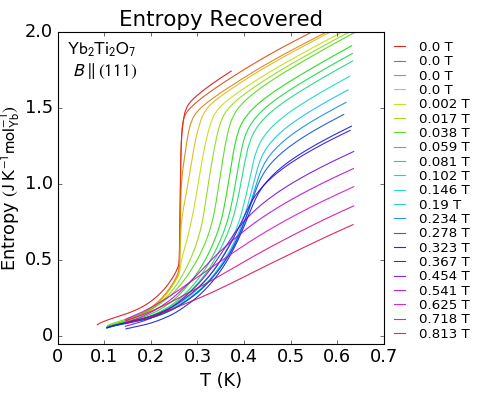

 computing entropy...


In [7]:
#***************
# Plot the entropy
#***************
f, ax = plt.subplots(1,1,figsize=(6,5))
f.subplots_adjust(left = 0.12,right = 0.80, bottom = 0.14, top = 0.92)
YbTiO.plotEntropy(ax,'All',smooth=6)
ax.set_ylim(-0.05,2)
ax.yaxis.set_major_formatter(FuncFormatter(my_formatter))
ax.xaxis.set_major_formatter(FuncFormatter(my_formatter))

ax.set_xlabel('T (K)')
ax.set_ylabel('Entropy $(\\rm{J\> K^{-1} mol^{-1}_{Yb}})$', labelpad = 3)
ax.set_title('Entropy Recovered')
ax.legend(handles=YbTiO.entropylabels,labelspacing = 0.1,handlelength=1.4,fontsize=12,
	frameon=False, bbox_to_anchor=(1.3, 1.01))
ax.text(0.03,0.97,'$\\rm{Yb_2Ti_2O_7}$\n $B \parallel (111)$',
	horizontalalignment='left',	verticalalignment='top',transform=ax.transAxes)

In [8]:
## Save the object with processed data to a file
# YbTiO.saveData('Yb2Ti2O7_processedData.pickle')

# Appendix A: scaling the wire conductivity

I noticed that, for our data files, the wire conductivity from the calibration file did not match the wire conductivity in the long-pulse data file. Naively, I would think they should be the same. I contacted Quantum Design, and they said that this reflects an actual change in wire conductivity, which is probably due to a poorer vacuum when the calibration was performed. So the only thing we can do is scale the wire thermal conductivity so that it roughly matches the wire conductivity as measured in the experiment.

I found that to do this successfully, I had to include a quadratic component. The following graph shows how I matched the two.

This scaling is applied at the very beginning of this IPython notebook.

<IPython.core.display.Javascript object>


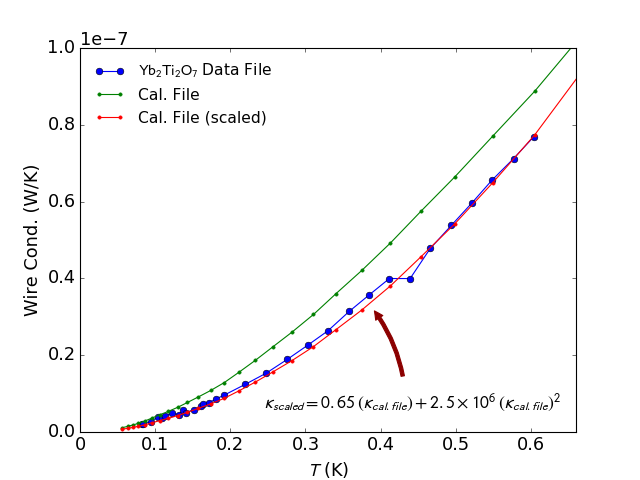

In [9]:
import matplotlib.patches as patches

# "Undo" the scaling performed in cell 2.
YbTiO.importCalibration(calfile=DRcalfile)


f, ax = plt.subplots(1,1)
#plt.plot(YbTiO.ThermCondWire[0],YbTiO.ThermCondWire[1], label='Data File')
plt.plot(YbTiO.avgThermCondWire[0],YbTiO.avgThermCondWire[1],
         marker = 'o', label='$\\rm Yb_2Ti_2O_7$ Data File')
plt.plot(YbTiO.Kw[0],YbTiO.Kw[1], marker = '.', label='Cal. File')  
plt.plot(YbTiO.Kw[0],YbTiO.Kw[1]*0.65 + 2.5e6*YbTiO.Kw[1]**2, marker = '.',
         label='Cal. File (scaled)') 
plt.xlim(0,0.66)
plt.ylim(0,10e-8)
plt.xlabel('$T$ (K)')
plt.ylabel('Wire Cond. (W/K)')
plt.legend(loc=2,fontsize=14, frameon=False)
ax.xaxis.set_major_formatter(FuncFormatter(my_formatter))
#ax.yaxis.set_major_formatter(FuncFormatter(my_formatter))
plt.text(0.97,0.05,'$\kappa_{scaled} = 0.65 \> (\kappa_{cal. file}) + 2.5 \\times 10^{6} \> (\kappa_{cal. file})^2$',
         horizontalalignment='right',
        verticalalignment = 'bottom',fontsize=16, transform=ax.transAxes)


ax.add_patch(patches.FancyArrowPatch(
        (0.43, 0.14e-7),
        (0.39, 0.32e-7),
        connectionstyle='arc3, rad=0.12', color='darkred',
        mutation_scale=17))


# Appendix B: Plotting Heating and Cooling Pulses Together


<IPython.core.display.Javascript object>


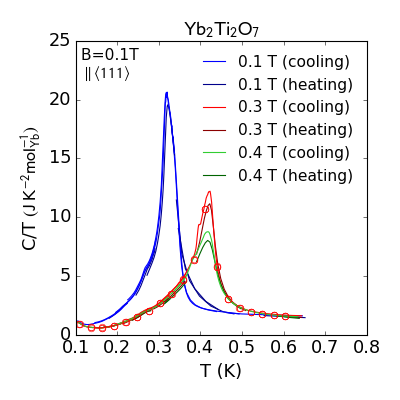

In [10]:
f, ax = plt.subplots(figsize=(5,5))

YbTiO.labels=[]
for jj in range(len(YbTiO.Bfield)):
	B = round(YbTiO.Bfield[jj],-1)
	if B == 1000:
		YbTiO.plotHCT(plt,index=jj,heatingcolor='darkblue',coolingcolor='blue',
			shortpulsecolor='steelblue',Blabels=True, demag=False)
	if B == 3000:
		YbTiO.plotHCT(plt,index=jj,heatingcolor='darkred',coolingcolor='red',
			shortpulsecolor='red',Blabels=True, demag=False)
	if B == 4000:
		YbTiO.plotHCT(plt,index=jj,heatingcolor='darkgreen',coolingcolor='limegreen',
			shortpulsecolor='green',Blabels=True, demag=False)

plt.xlabel("T (K)")
plt.ylabel("C/T $(\\rm{J\> K^{-2} mol^{-1}_{Yb}})$")
#plt.yscale('log')
plt.title('$\\rm{Yb_2Ti_2O_7}$', fontsize=18)
plt.text(0.02,0.97,'B=0.1T \n$\parallel \\langle 111 \\rangle$',horizontalalignment='left',
	verticalalignment = 'top',fontsize=14, transform=ax.transAxes)
plt.legend(handles=YbTiO.labels,numpoints=1, fontsize=14, handlelength=1.4, frameon=False)
#plt.ylim(0,37)
plt.xlim(0.1,0.8)
plt.tight_layout()
